<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_10/ResNet18_modes_of_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Transfer Learning - ResNet18 pré treinada**

 Utilizando o modelo resnet18 com os pesos pré-treinados do ImageNet  para avaliar o dataset MNIST.

Importando bibliotecas necessárias:

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import time

Device: usa GPU se disponível

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Treinando em:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Treinando em: cuda
GPU: Tesla T4


Transformações para ResNet (ImageNet):

In [ ]:
trans_ResNet_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalização ImageNet
])

trans_ResNet_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



---
Funções para a criar os 3 modelos de treinamento:


In [ ]:
def create_resnet18_FC():
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    # descongela só a última camada FC
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)  # 10 classes do MNIST

    return model


def create_resnet18_layer4_e_Fc():
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    # descongela a Layer 4
    for param in model.layer4.parameters():
        param.requires_grad = True

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    return model


def create_resnet18_finetuning_total():
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    # última camada FC para 10 classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    return model

### Modularizando em funções

Função para carregar o dataset:

In [ ]:
def load_data(trans_train, trans_test, batch_size=32):
    root_path = '/content'  # colab usa /content

    train_dataset_full = torchvision.datasets.MNIST(
        root=root_path, train=True, transform=trans_train, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root=root_path, train=False, transform=trans_test
    )

    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

    num_workers = 2
    pin_memory = True if device.type == "cuda" else False

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader, test_loader


Função para executar uma época de treinamento:

In [ ]:
def train_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Forward + loss
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Métricas
        predicted = outputs.argmax(dim=1)
        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * running_correct / running_total

    return epoch_loss, epoch_acc

Função que avalia o modelo em um dataset:

In [ ]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    f1_per_class = f1_score(all_labels, all_predictions, average=None)

    return avg_loss, accuracy, f1_macro, f1_weighted, f1_per_class, all_predictions, all_labels

Função de treinamento principal:

In [ ]:
def train_model(model_name, model, trans_train, trans_test,
                epochs=6, learning_rate=0.001, batch_size=32):
    print(f"Treinando o modelo: {model_name}")

    # carrega dados
    train_loader, val_loader, test_loader = load_data(trans_train, trans_test, batch_size)

    # prepara modelo
    model = model.to(device)
    parametros_total = sum(p.numel() for p in model.parameters())
    parametros_treinaveis = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parâmetros treináveis: {parametros_treinaveis:,}")

    # configura treinamento
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    torch.backends.cudnn.benchmark = True if device.type == "cuda" else False

    train_losses, train_accuracies, train_f1_scores = [], [], []
    val_losses, val_accuracies, val_f1_scores = [], [], []
    best_val_acc = 0.0

    start_time = time.time()

    # loop de treinamento
    for epoch in range(epochs):
        # treina
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # valida
        val_loss, val_acc, val_f1_macro, val_f1_weighted, _, _, _ = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1_macro * 100)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"Época [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1_macro*100:.2f}%")

    # avaliação final no teste
    test_loss, test_accuracy, test_f1_macro, test_f1_weighted, test_f1_per_class, predictions, labels = \
      evaluate(model, test_loader, loss_fn)
    training_time = time.time() - start_time

    print(f"Acurácia no Teste: {test_accuracy:.3f}%")
    print(f"Melhor Acurácia na Validação: {best_val_acc:.2f}%")
    print(f"Tempo de Treinamento: {training_time:.2f}s")

    return {
        'name': model_name,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores,
        'test_accuracy': test_accuracy,
        'test_f1_macro': test_f1_macro * 100,
        'test_f1_weighted': test_f1_weighted * 100,
        'test_f1_per_class': test_f1_per_class * 100,
        'best_val_acc': best_val_acc,
        'training_time': training_time,
        'num_params': parametros_treinaveis,
        'predictions': predictions,
        'labels': labels
    }



---
Execução principal


In [ ]:
resultados = []

3.1 - Apenas FC treinável

In [ ]:
model_frozen_all = create_resnet18_FC()
resultados.append(train_model("ResNet18 - Congela Tudo (apenas FC)",
                               model_frozen_all,
                               trans_ResNet_train,
                               trans_ResNet_test))

Treinando o modelo: ResNet18 - Congela Tudo (apenas FC)
Parâmetros treináveis: 5,130
Época [1/6] - Train Loss: 0.4811, Train Acc: 86.95% | Val Loss: 0.2840, Val Acc: 91.40%, Val F1: 91.30%
Época [2/6] - Train Loss: 0.2599, Train Acc: 92.09% | Val Loss: 0.2288, Val Acc: 92.64%, Val F1: 92.58%
Época [3/6] - Train Loss: 0.2283, Train Acc: 92.98% | Val Loss: 0.1833, Val Acc: 94.42%, Val F1: 94.35%
Época [4/6] - Train Loss: 0.2127, Train Acc: 93.25% | Val Loss: 0.1833, Val Acc: 94.23%, Val F1: 94.15%
Época [5/6] - Train Loss: 0.2052, Train Acc: 93.40% | Val Loss: 0.1610, Val Acc: 94.94%, Val F1: 94.89%
Época [6/6] - Train Loss: 0.1918, Train Acc: 93.94% | Val Loss: 0.1668, Val Acc: 94.77%, Val F1: 94.70%
Acurácia no Teste: 93.840%
Melhor Acurácia na Validação: 94.94%
Tempo de Treinamento: 775.17s


3.2 - Layer 4 + FC treináveis

In [ ]:
model_frozen_partial = create_resnet18_layer4_e_Fc()
resultados.append(train_model("ResNet18 - Fine-tuning parcial (Layer4 + FC)",
                               model_frozen_partial,
                               trans_ResNet_train,
                               trans_ResNet_test))

Treinando o modelo: ResNet18 - Fine-tuning parcial (Layer4 + FC)
Parâmetros treináveis: 8,398,858
Época [1/6] - Train Loss: 0.0832, Train Acc: 97.45% | Val Loss: 0.0486, Val Acc: 98.47%, Val F1: 98.46%
Época [2/6] - Train Loss: 0.0428, Train Acc: 98.72% | Val Loss: 0.0403, Val Acc: 98.72%, Val F1: 98.70%
Época [3/6] - Train Loss: 0.0318, Train Acc: 99.05% | Val Loss: 0.0303, Val Acc: 99.10%, Val F1: 99.10%
Época [4/6] - Train Loss: 0.0276, Train Acc: 99.16% | Val Loss: 0.0313, Val Acc: 99.11%, Val F1: 99.10%
Época [5/6] - Train Loss: 0.0225, Train Acc: 99.32% | Val Loss: 0.0351, Val Acc: 99.05%, Val F1: 99.05%
Época [6/6] - Train Loss: 0.0187, Train Acc: 99.43% | Val Loss: 0.0290, Val Acc: 99.25%, Val F1: 99.25%
Acurácia no Teste: 99.370%
Melhor Acurácia na Validação: 99.25%
Tempo de Treinamento: 787.33s


3.3 - Fine-tuning total

In [ ]:
model_finetuning_full = create_resnet18_finetuning_total()
resultados.append(train_model("ResNet18 - Fine-tuning total",
                               model_finetuning_full,
                               trans_ResNet_train,
                               trans_ResNet_test))

Treinando o modelo: ResNet18 - Fine-tuning total
Parâmetros treináveis: 11,181,642
Época [1/6] - Train Loss: 0.0889, Train Acc: 97.32% | Val Loss: 0.0544, Val Acc: 98.47%, Val F1: 98.48%
Época [2/6] - Train Loss: 0.0490, Train Acc: 98.53% | Val Loss: 0.0397, Val Acc: 98.77%, Val F1: 98.77%
Época [3/6] - Train Loss: 0.0383, Train Acc: 98.83% | Val Loss: 0.0722, Val Acc: 97.90%, Val F1: 97.90%
Época [4/6] - Train Loss: 0.0344, Train Acc: 98.93% | Val Loss: 0.0341, Val Acc: 99.00%, Val F1: 99.00%
Época [5/6] - Train Loss: 0.0269, Train Acc: 99.15% | Val Loss: 0.0324, Val Acc: 99.24%, Val F1: 99.24%
Época [6/6] - Train Loss: 0.0267, Train Acc: 99.18% | Val Loss: 0.0350, Val Acc: 98.94%, Val F1: 98.94%
Acurácia no Teste: 99.240%
Melhor Acurácia na Validação: 99.24%
Tempo de Treinamento: 1042.78s




---
### Visualizando os resultados

Para plotar matriz de confusão

Função para comparação do F1-score

In [ ]:
def plot_f1_comparison(resultados):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # F1-score ao longo das épocas
    ax = axes[0]
    for res in resultados:
        ax.plot(range(1, len(res['val_f1_scores'])+1),
               res['val_f1_scores'], marker='o',
               label=res['name'].split('-')[1].strip())
    ax.set_xlabel('Época')
    ax.set_ylabel('F1-Score Macro (%)')
    ax.set_title('F1-Score de Validação por Época')
    ax.legend()
    ax.grid(True)

    # F1-score final no teste
    ax = axes[1]
    names = []
    for res in resultados:
      if "ResNet18 - Congela Tudo (apenas FC)" in res['name']:
          names.append("Apenas FC")
      elif "ResNet18 - Fine-tuning parcial (Layer4 + FC)" in res['name']:
          names.append("Layer4 + FC")
      elif "ResNet18 - Fine-tuning total" in res['name']:
          names.append("Fine-tuning Total")
      else:
          names.append(res['name'].split('-')[1].strip() if '-' in res['name'] else res['name'])
    f1_macros = [res['test_f1_macro'] for res in resultados]
    f1_weighteds = [res['test_f1_weighted'] for res in resultados]

    x = np.arange(len(names))
    width = 0.35

    ax.bar(x - width/2, f1_macros, width, label='F1-Macro', color='#4ECDC4')
    ax.bar(x + width/2, f1_weighteds, width, label='F1-Weighted', color='#45B7D1')

    ax.set_ylabel('F1-Score (%)')
    ax.set_title('F1-Score no Teste')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()
    ax.set_ylim([min(min(f1_macros), min(f1_weighteds))-5, 100])

    for i, (v1, v2) in enumerate(zip(f1_macros, f1_weighteds)):
        ax.text(i - width/2, v1+1, f'{v1:.2f}%', ha='center', va='bottom', fontsize=9)
        ax.text(i + width/2, v2+1, f'{v2:.2f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


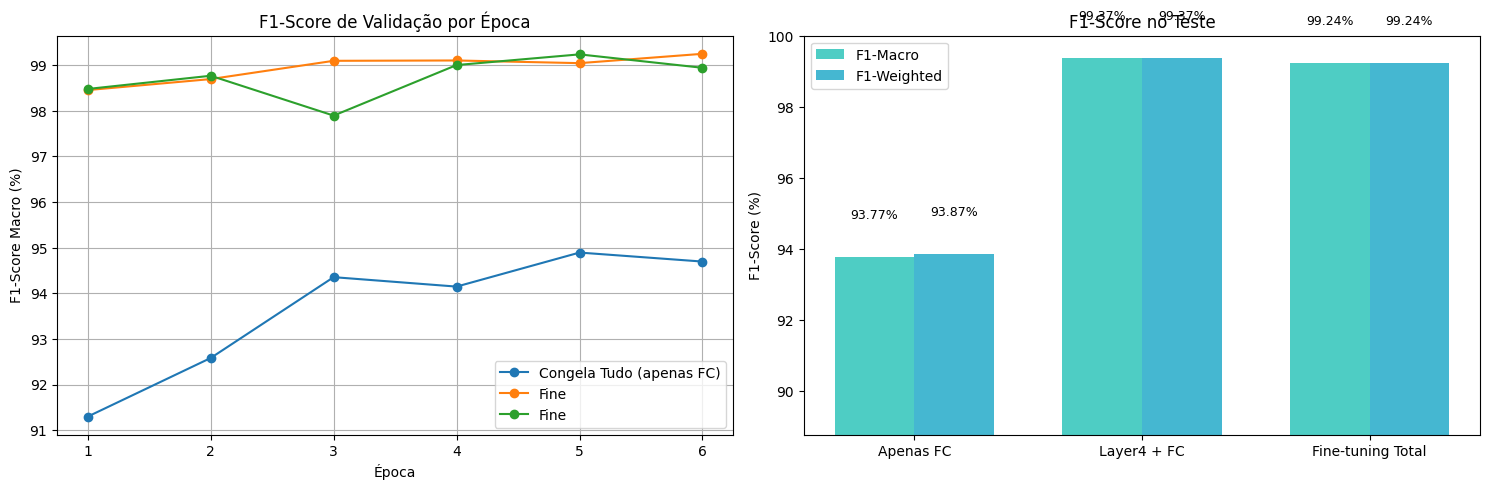

In [ ]:
plot_f1_comparison(resultados)

F1-score por classe:



In [ ]:
def plot_f1_per_class(resultados):
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(10)  # 10 classes (dígitos 0-9)
    width = 0.25

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for idx, res in enumerate(resultados):
        offset = (idx - len(resultados)/2 + 0.5) * width
        ax.bar(x + offset, res['test_f1_per_class'], width,
              label=res['name'],
              color=colors[idx % len(colors)])

    ax.set_xlabel('Classe (Dígito)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_title('F1-Score por Classe no Conjunto de Teste')
    ax.set_xticks(x)
    ax.set_xticklabels(range(10))
    ax.legend()
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 105])

    plt.tight_layout()
    plt.show()

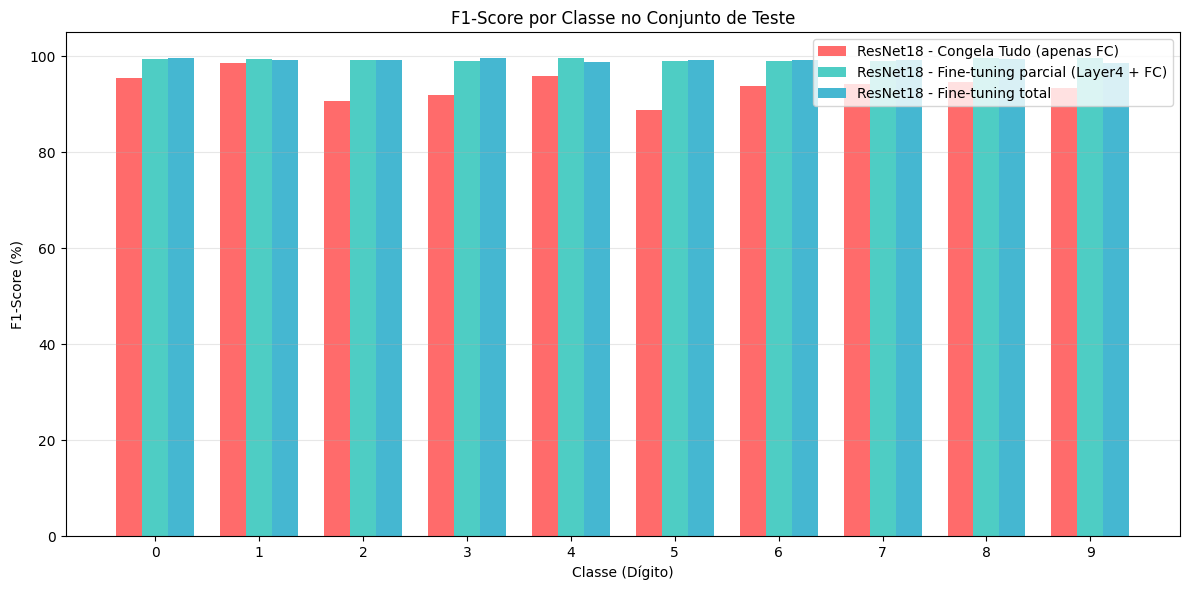

In [ ]:
plot_f1_per_class(resultados)

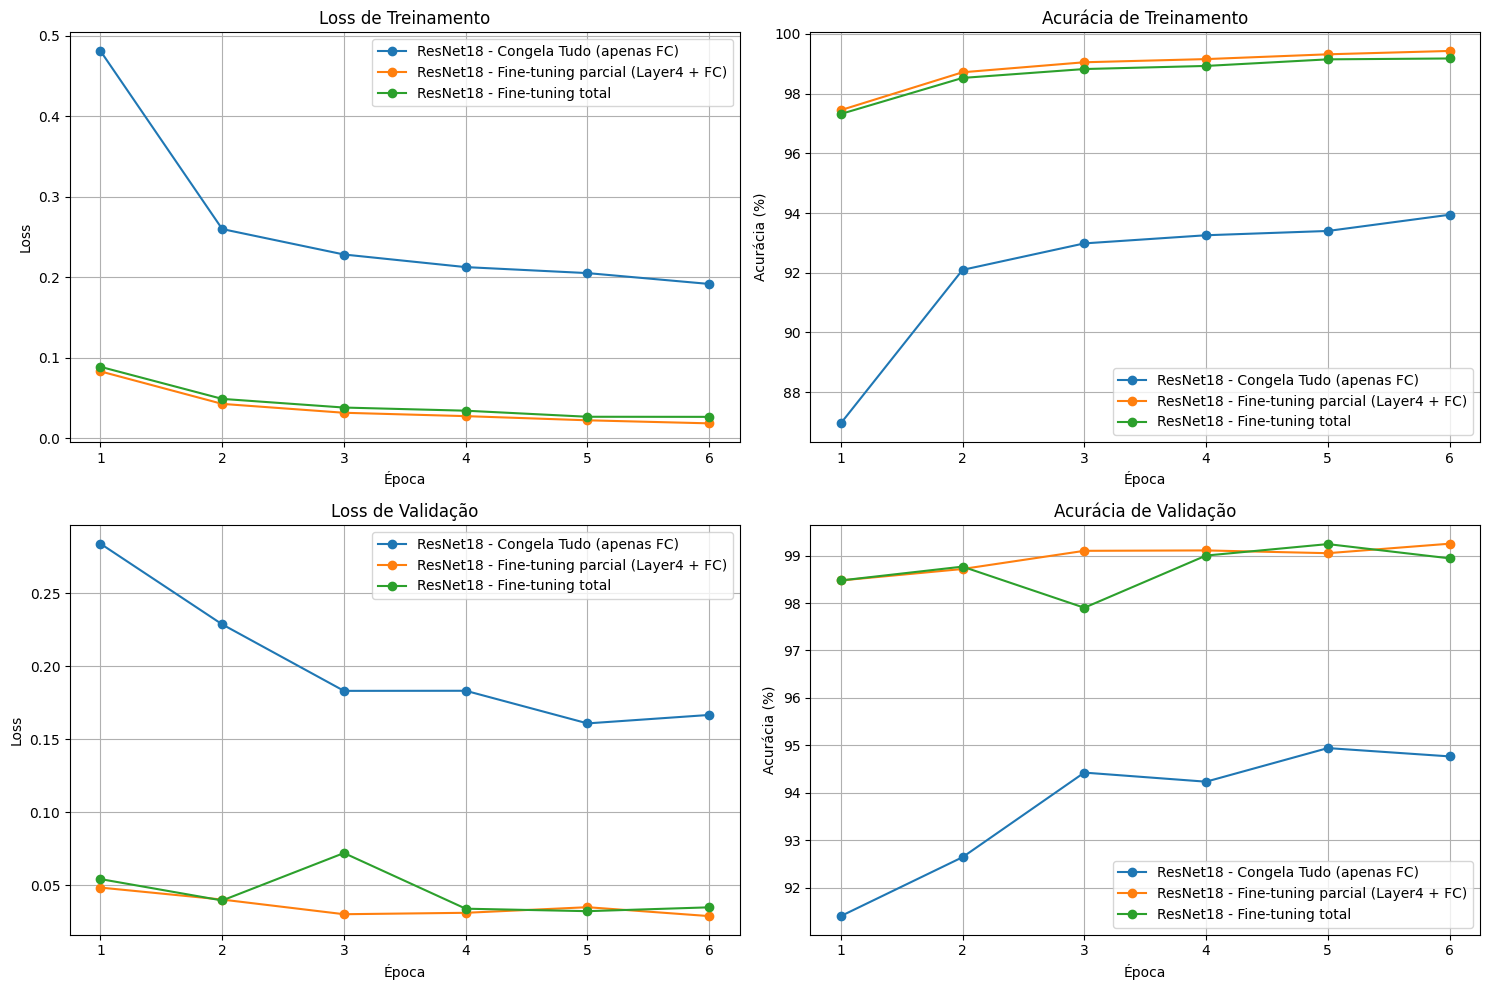

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# perda de treino
ax = axes[0, 0]
for res in resultados:
    ax.plot(range(1, len(res['train_losses'])+1), res['train_losses'], marker='o', label=res['name'])
ax.set_xlabel('Época')
ax.set_ylabel('Loss')
ax.set_title('Loss de Treinamento')
ax.legend()
ax.grid(True)

# acurácia de treino
ax = axes[0, 1]
for res in resultados:
    ax.plot(range(1, len(res['train_accuracies'])+1), res['train_accuracies'], marker='o', label=res['name'])
ax.set_xlabel('Época')
ax.set_ylabel('Acurácia (%)')
ax.set_title('Acurácia de Treinamento')
ax.legend()
ax.grid(True)

# perda de validação
ax = axes[1, 0]
for res in resultados:
    ax.plot(range(1, len(res['val_losses'])+1), res['val_losses'], marker='o', label=res['name'])
ax.set_xlabel('Época')
ax.set_ylabel('Loss')
ax.set_title('Loss de Validação')
ax.legend()
ax.grid(True)

# acurácia de validação
ax = axes[1, 1]
for res in resultados:
    ax.plot(range(1, len(res['val_accuracies'])+1), res['val_accuracies'], marker='o', label=res['name'])
ax.set_xlabel('Época')
ax.set_ylabel('Acurácia (%)')
ax.set_title('Acurácia de Validação')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

Gráfico de barras para a comparação

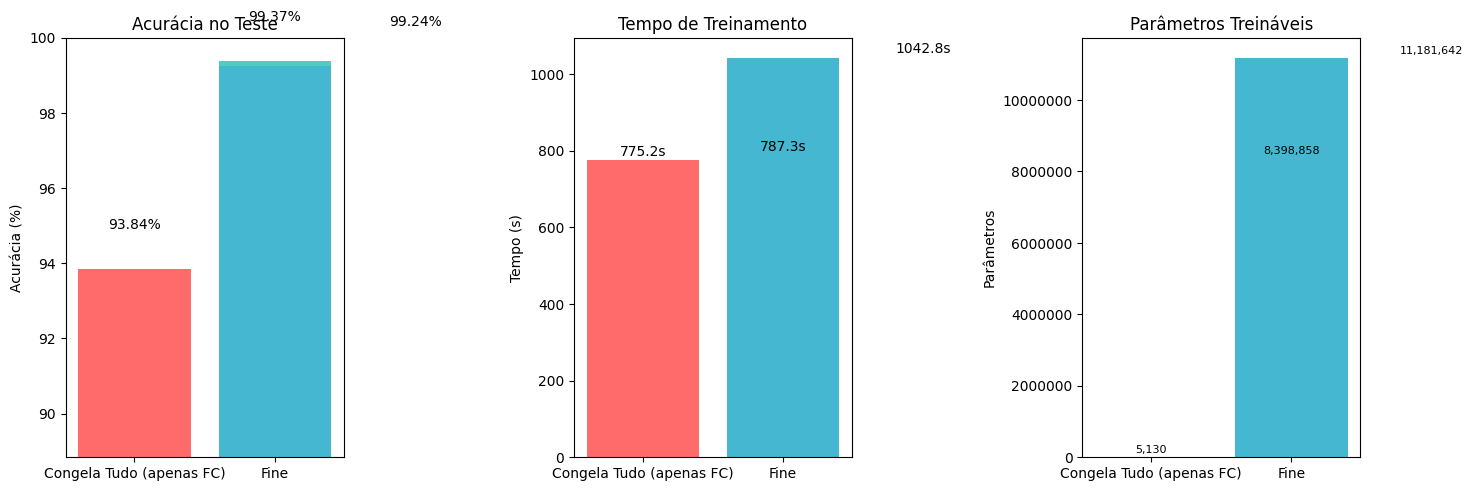

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# acurácia de teste
ax = axes[0]
names = [res['name'].split('-')[1].strip() for res in resultados]
test_accs = [res['test_accuracy'] for res in resultados]
ax.bar(names, test_accs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_ylabel('Acurácia (%)')
ax.set_title('Acurácia no Teste')
ax.set_ylim([min(test_accs)-5, 100])
for i, v in enumerate(test_accs):
    ax.text(i, v+1, f'{v:.2f}%', ha='center', va='bottom')

# tempo de treinamento
ax = axes[1]
times = [res['training_time'] for res in resultados]
ax.bar(names, times, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_ylabel('Tempo (s)')
ax.set_title('Tempo de Treinamento')
for i, v in enumerate(times):
    ax.text(i, v+5, f'{v:.1f}s', ha='center', va='bottom')

# parâmetros treináveis
ax = axes[2]
params = [res['num_params'] for res in resultados]
ax.bar(names, params, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_ylabel('Parâmetros')
ax.set_title('Parâmetros Treináveis')
ax.ticklabel_format(style='plain', axis='y')
for i, v in enumerate(params):
    ax.text(i, v+50000, f'{v:,}', ha='center', va='bottom', rotation=0, fontsize=8)

plt.tight_layout()
plt.show()